In [21]:
# Preparamos el entorno de trabajo para todo el flujo.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path
from IPython.display import display, Markdown
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score

# Implementación de Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import shap

#Evaluación del Modelo mediante Classification Report
from sklearn.metrics import classification_report

#Implementación LIME
from lime.lime_tabular import LimeTabularExplainer
import numpy as np

In [22]:
# Configuración global para reproducibilidad y estilo de gráficos
RANDOM_STATE = 42
RESULTS_DIR = Path('../Results')
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

sns.set_theme(style='whitegrid')
plt.rcParams['figure.dpi'] = 120

In [23]:
# Comprensión del dataset
df = pd.read_excel('../Dataset/citaschallenge.xlsx')

print(df.head())
print(df.info())
print(df.describe(include='all'))

     GENERO  EDAD         ESPECIALIDAD TIPO_AFILIACION          FECHA_CITA  \
0  FEMENINO  41.0           ORTODONCIA            GOLD 2013-07-02 06:30:00   
1  FEMENINO  49.0  TERAPIA OCUPACIONAL          SILVER 2013-07-02 06:30:00   
2  FEMENINO  41.0         FISIOTERAPIA            GOLD 2013-07-02 06:30:00   
3  FEMENINO  49.0         FISIOTERAPIA            GOLD 2013-07-02 06:50:00   
4  FEMENINO  36.0           RADIOLOGIA            GOLD 2013-07-02 06:50:00   

      id  ESTAFINAL  
0   9373          3  
1  62884          2  
2  72568          2  
3   5733          1  
4  22397          3  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67650 entries, 0 to 67649
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   GENERO           67650 non-null  object        
 1   EDAD             67650 non-null  float64       
 2   ESPECIALIDAD     67650 non-null  object        
 3   TIPO_AFILIACION  6765

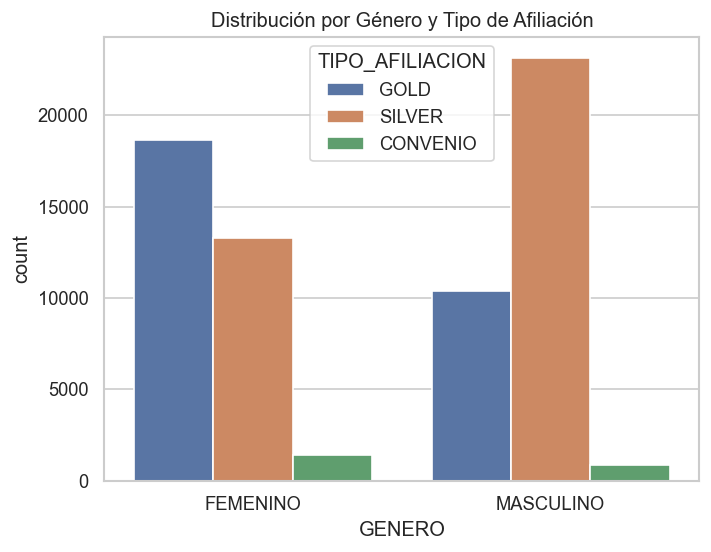

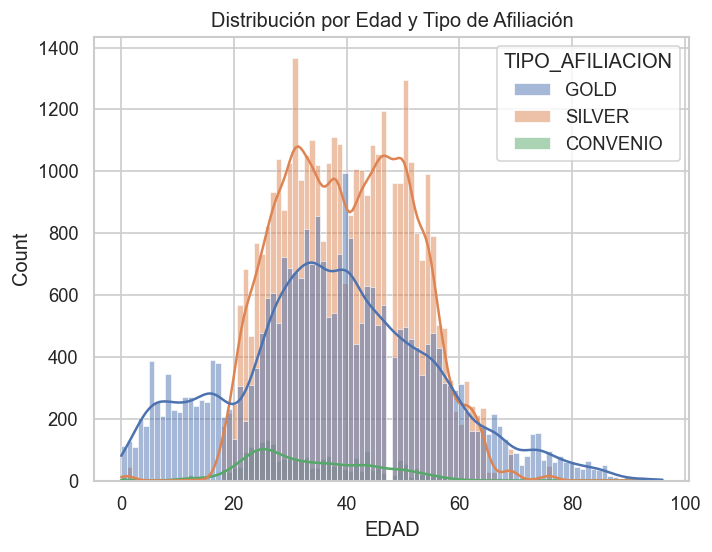

GENERO
FEMENINO     55.924213
MASCULINO    30.166540
dtype: float64


In [24]:
# Análisis Exploratorio

#Distribución por Género y Tipo de Afiliación
sns.countplot(data=df, x='GENERO', hue='TIPO_AFILIACION')
plt.title('Distribución por Género y Tipo de Afiliación')
plt.show()

# Distribución por Edad y Tipo de Afiliiación
sns.histplot(data=df, x='EDAD', hue='TIPO_AFILIACION', kde=True)
plt.title('Distribución por Edad y Tipo de Afiliación')
plt.show()

# Tasa de Afiliación Gold por Género
gold_by_gender = df[df['TIPO_AFILIACION'] == 'GOLD'].groupby('GENERO').size()
total_by_gender = df.groupby('GENERO').size()
tasa_gold_by_gender = gold_by_gender / total_by_gender * 100
print(tasa_gold_by_gender)

In [25]:
# Limpieza y preprocesamiento
print('Valores nulos por columna:')
print(df.isnull().sum())


print(f'\nCantidad de filas duplicadas: {df.duplicated().sum()}')

# Definimos mapeos para transformar variables categoricas a numericas.
gender_map = {'FEMENINO': 0, 'MASCULINO': 1}
affiliation_map = {'CONVENIO': 1, 'SILVER': 2, 'GOLD': 3}

df['GENERO'] = df['GENERO'].str.upper().map(gender_map)
df['TIPO_AFILIACION'] = df['TIPO_AFILIACION'].str.upper().map(affiliation_map)

if df['GENERO'].isnull().any():
    faltantes = sorted(df.loc[df['GENERO'].isnull(), 'GENERO'].astype(str).unique())
    raise ValueError(f'Valores inesperados en GENERO tras mapeo: {faltantes}')

if df['TIPO_AFILIACION'].isnull().any():
    faltantes = sorted(df.loc[df['TIPO_AFILIACION'].isnull(), 'TIPO_AFILIACION'].astype(str).unique())
    raise ValueError(f'Valores inesperados en TIPO_AFILIACION tras mapeo: {faltantes}')

df['GENERO'] = df['GENERO'].astype(int)
df['EDAD'] = df['EDAD'].astype(int)
df['TIPO_AFILIACION'] = df['TIPO_AFILIACION'].astype(int)


print('\nTipos de datos luego de limpieza:')
print(df.dtypes)

Valores nulos por columna:
GENERO             0
EDAD               0
ESPECIALIDAD       0
TIPO_AFILIACION    0
FECHA_CITA         0
id                 0
ESTAFINAL          0
dtype: int64

Cantidad de filas duplicadas: 0

Tipos de datos luego de limpieza:
GENERO                      int64
EDAD                        int64
ESPECIALIDAD               object
TIPO_AFILIACION             int64
FECHA_CITA         datetime64[ns]
id                          int64
ESTAFINAL                   int64
dtype: object


In [26]:
# Escalado
X = df[['GENERO', 'EDAD', 'ESTAFINAL', 'TIPO_AFILIACION']]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Precisión del Modelo: 59.28%


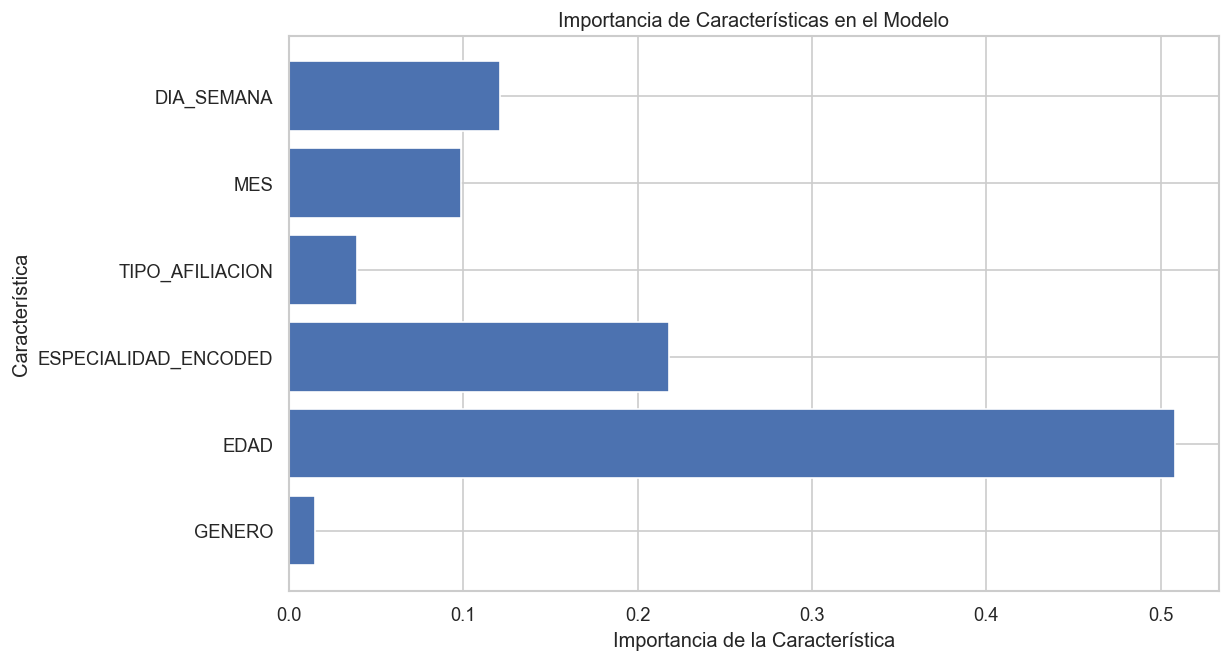

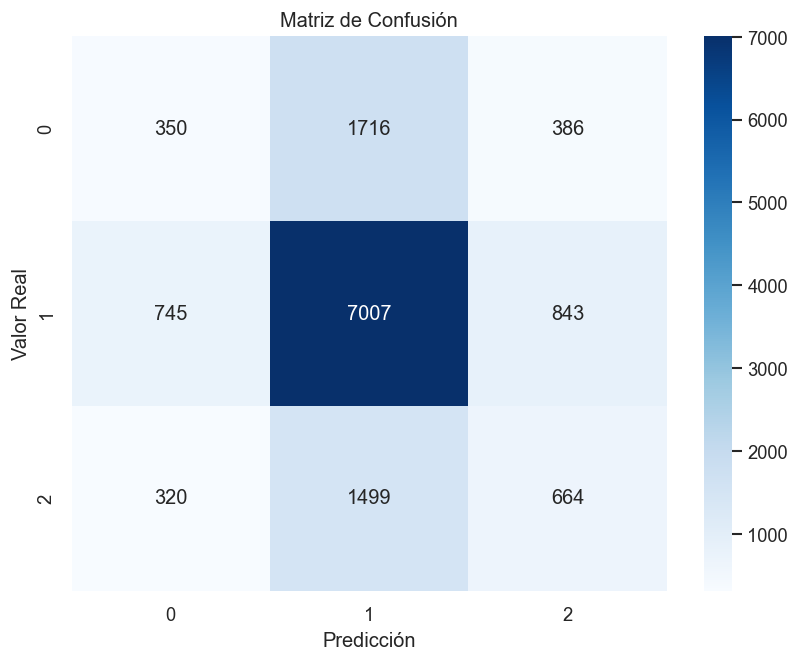

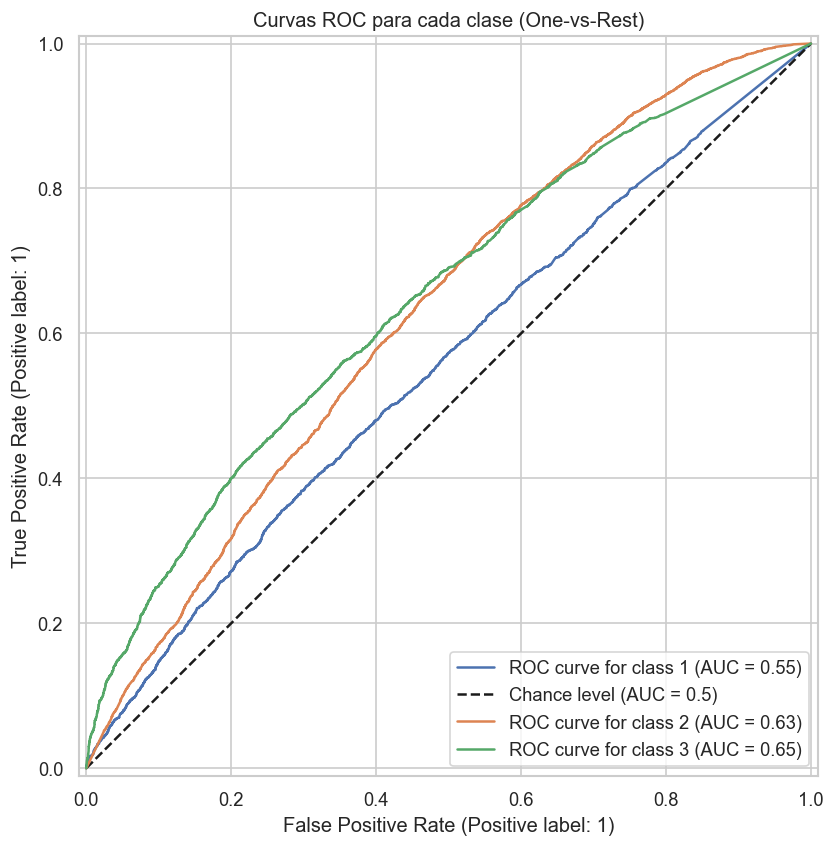

In [27]:


# Feature Engineering para FECHA_CITA
df['MES'] = df['FECHA_CITA'].dt.month
df['DIA_SEMANA'] = df['FECHA_CITA'].dt.dayofweek

# Codificación de 'ESPECIALIDAD'
df_encondeded = df.copy()
le = LabelEncoder()
df['ESPECIALIDAD_ENCODED'] = le.fit_transform(df['ESPECIALIDAD'])

# Definir características (X) y objetivo (y)
features = ['GENERO', 'EDAD', 'ESPECIALIDAD_ENCODED', 'TIPO_AFILIACION', 'MES', 'DIA_SEMANA']
X = df[features]
y = df['ESTAFINAL']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenamiento del Modelo
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluación del Modelo
accuracy = model.score(X_test, y_test)
print(f'Precisión del Modelo: {accuracy * 100:.2f}%')

# Importancia de Características del Modelo
feature_importances = model.feature_importances_
feature_names = features
plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importances)
plt.xlabel('Importancia de la Característica')
plt.ylabel('Característica')
plt.title('Importancia de Características en el Modelo')
plt.show()

# Matriz de Confusión
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión')
plt.show()

# Curva ROC y AUC para clasificación multiclase (One-vs-Rest)
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

y_pred_proba = model.predict_proba(X_test)

# Get unique classes from y_test and sort them
classes = sorted(y_test.unique())

plt.figure(figsize=(10, 8))
for i, class_id in enumerate(classes):
    # Create a binary target for the current class (one-vs-rest)
    y_test_binary = (y_test == class_id)

    # Plot ROC curve for the current class
    RocCurveDisplay.from_predictions(
        y_test_binary,
        y_pred_proba[:, i], # Probability of the current class
        name=f'ROC curve for class {class_id}',
        ax=plt.gca(),
        plot_chance_level=(i == 0) # Plot chance level only once
    )

plt.title('Curvas ROC para cada clase (One-vs-Rest)')
plt.show()

In [28]:
y_pred = model.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           1       0.25      0.14      0.18      2452
           2       0.69      0.82      0.74      8595
           3       0.35      0.27      0.30      2483

    accuracy                           0.59     13530
   macro avg       0.43      0.41      0.41     13530
weighted avg       0.54      0.59      0.56     13530



In [29]:
#!pip install shap

In [ ]:
# Implementación SHAP correctamente definida para TIPO_AFILIACION
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import shap
# Selecciona las columnas relevantes para el modelo de TIPO_AFILIACION
features_to_drop_from_X = ['TIPO_AFILIACION', 'GENERO', 'FECHA_CITA', 'id', 'ESPECIALIDAD', 'ESTAFINAL']
X_shap = df.drop(columns=features_to_drop_from_X, errors='ignore')
y_shap = df['TIPO_AFILIACION']
# Divide los datos para SHAP
X_train_shap, X_test_shap, y_train_shap, y_test_shap = train_test_split(X_shap, y_shap, random_state=43, test_size=0.3)
# Entrena el modelo para SHAP
model_shap = RandomForestClassifier(random_state=42)
model_shap.fit(X_train_shap, y_train_shap)
# Define explainer_shap y calcula shap_values
explainer_shap = shap.TreeExplainer(model_shap, X_train_shap)
shap_values = explainer_shap(X_test_shap)
# X_test_df para visualizaciones individuales
X_test_df = X_test_shap.copy()
# Importancia media de cada variable
num_features_in_shap_output = shap_values.values[:, 1, :].shape[1]
shap_values_array = pd.DataFrame(shap_values.values[:, 1, :], columns=shap_values.feature_names[:num_features_in_shap_output])
shap_df = pd.DataFrame(shap_values_array, columns=shap_values.feature_names[:num_features_in_shap_output])
meas_abs_shap = shap_df.abs().mean().sort_values(ascending=False)
# Visualización de importancia media
meas_abs_shap.head(10).plot(kind='bar', title = 'Importancia media de cada variable')
plt.show()

 25%|=====               | 15340/60885 [04:01<11:55]       

In [ ]:
#Uso de datos originales con variables catergóricas codificadas
feature_names = X_train.columns.tolist()

#Crear explicador para TIPO_AFILIACION
explainer = LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=feature_names,
    class_names=['Convenio', 'Gold', 'Silver'],
    mode='classification',
    discretize_continuous=True
)

#Seleccionar un ejemplo individual a explicar
i = 10  # índice del ejemplo a explicar
exp = explainer.explain_instance(
    data_row=X_test.iloc[i],
    predict_fn=model.predict_proba,
    num_features=10
)

#Mostrar Explicaciones
exp.show_in_notebook(show_table=True, show_all=False)


In [ ]:
# Implementación LIME para explicabilidad individual
from lime.lime_tabular import LimeTabularExplainer
import numpy as np
feature_names = X_train.columns.tolist()
explainer = LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=feature_names,
    class_names=['Convenio', 'Gold', 'Silver'],
    mode='classification',
    discretize_continuous=True
)
# Seleccionar dos ejemplos individuales a explicar
indices = [10, 25] # Puedes cambiar los índices según el caso
lime_explanations = []
for i in indices:
    exp = explainer.explain_instance(
        data_row=X_test.iloc[i],
        predict_fn=model.predict_proba,
        num_features=10
)
    lime_explanations.append(exp)
    exp.show_in_notebook(show_table=True, show_all=False)

In [ ]:
# Visualización de variables que más influyen en la decisión según LIME
import matplotlib.pyplot as plt
for idx, exp in enumerate(lime_explanations):
    fig = exp.as_pyplot_figure()
    plt.title(f'Explicación LIME para ejemplo {indices[idx]}')
    plt.show()

In [ ]:
# Comparación de explicaciones entre SHAP y LIME para los mismos ejemplos
# Visualización SHAP para los mismos ejemplos
for idx in indices:
    shap.force_plot(
        explainer_shap.expected_value[1],
        shap_values.values[idx, 1, :],
        shap_values.feature_names[:shap_values.values.shape[2]],  # Pasa los nombres de las features
        matplotlib=True
    )

## Explicaciones individuales de predicciones concretas (2 ejemplos)
A continuación se muestran las explicaciones generadas por LIME y SHAP para dos ejemplos concretos del conjunto de prueba. Estas visualizaciones permiten entender cómo cada variable contribuye a la decisión del modelo en casos específicos.
- **Ejemplo 1:** Índice 10 del conjunto de prueba.
- **Ejemplo 2:** Índice 25 del conjunto de prueba.
Las gráficas muestran la importancia relativa de cada variable y cómo influyen en la predicción final. Comparar ambas técnicas ayuda a identificar coincidencias y diferencias en la interpretación del modelo.

In [ ]:
# Visualizaciones adicionales: Variables con mayor impacto y comparación de técnicas
plt.figure(figsize=(12, 6))
meas_abs_shap.head(10).plot(kind='bar', color='skyblue', title='Importancia media de variables según SHAP')
plt.ylabel('Valor medio absoluto SHAP')
plt.show()

# Comparación visual entre LIME y SHAP para el primer ejemplo
lime_weights = dict(lime_explanations[0].as_list())
shap_weights = shap_values.values[indices[0], 1, :]
shap_features = shap_values.feature_names[:len(shap_weights)]
plt.figure(figsize=(12, 6))
plt.bar(lime_weights.keys(), lime_weights.values(), alpha=0.7, label='LIME')
plt.bar(shap_features, shap_weights, alpha=0.7, label='SHAP')
plt.title('Comparación de importancia de variables: LIME vs SHAP (Ejemplo 1)')
plt.ylabel('Peso')
plt.legend()
plt.show()

## Análisis Interpretativo

### Transparencia del Modelo:
La transparencia técnica del modelo se identifica como moderada; se logra explicar, con herramientas como LIME, cómo se descomponen las decisiones locales del modelo en factores comprensibles, con rangos de edad o tipos de afiliación específicos, hacia el estado final de las citas, es decir, si hubo cumplimiento o insistencia.

### Riesgos éticos y sociales si se implementa el sistema:
Se identificaron 3 riesgos principales:
1. Sesgo debido al tipo de afiliación: esto quiere decir que el modelo puede aprender y perpetuar desigualdades basadas en el nivel socioeconómico. Cuando el Tipo de Afiliación es una variable principal, el sistema puede priorizar o penalizar a ciertos grupos basados en el tipo de afiliación que pudieron adquirir.
2. Discriminación por Edad o Género: las distribuciones en el modelo fueron visualizadas en el análisis exploratorio; en caso de que el modelo asocie erróneamente el incumplimiento de ctias con género o edad específicos, podría generar sesgos en el acceso a la salud para esos grupos.
3. Deshumanización: ejecutar tareas como gestión de citas de manera automatizadas basados en parámetros como probabilidades de asistencia sin considerar factores como problemas en transporte o emergencias, podría afectar el acceso a los servicios médicos.

### Consideraciones para mejorar el modelo:
1. Inclusión de variables externas para automatizaciones: el uso de datos como clima, tráfico o ubicación del paciente puede ayudar a entender las causas del incumplimiento de citas.
2. Balanceo de datos: asegurar que las clases para la interpretación del estado final de la cita estén equilibradas para evitar que el modelo sesgue hacia clases mayoritarias.
3. Monitoreo del modelo: implementar sistemas de auditoría para analizar sesgos y detectar si el modelo comienza a discriminar a grupos vulnerables con el tiempo.

### Reflexión sobre el proceso

¿Qué aprendizaje desarrolló sobre cómo el modelo toma decisiones?:
Se aprendió que el tipo de decisiones del modelo no es lineal, sino que analiza varias características de manera simultánea; adicionalmente, LIME nos ayuda a ver que, para predicciones de variables como Tipo de Afiliación, dentro de ciertos rangos de edad, como por ejemplo menor a 29 años, actúan basados en la probabilidad de la clase final, dado que el modelo busca patrones históricos en las combinaciones para seleccionar un resultado y darle su peso.

¿Hay alguna variable que tenga un peso excesivo?:
Basados en el análisis  de explicación de variables, vimos que TIPO_ESPECIALIDAD y ESPECIALIDAD parecen tener influencia significativa en los resultados de las predicciones en el modelo. Se puede tener como ejemplo que el rango de afiliación marca un peso negativo de 0.19, marcando un factor determinante para esa predicción.

¿Qué pasaría si este modelo se implementa sin explicabilidad?:
Esto podría generar problemas como falta de confianza dado que personal administrativo y médicos, no entenderían por que el sistema marcaría a un paciente como propenso a no asistir. Otro problema sería la falta de capacidad para corregir errores, el modelo tomaría decisiones basados en sesgos, y no se sabría como identificar que variable causa esto y ajustarla. Finalmente, el paciente no tendría una justificación clara de por qué se le ha negado una cita basada en una predicción automatizada.
